In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
import pandas as pd
import re
import random
import string
import matplotlib.pyplot as plt
from utilities import clean_arabic_tweet
from utilities import remove_repeating_char, remove_punctuations, remove_diacritics, normalize_arabic, remove_single_char_word
from utilities import remove_common_words, remove_duplicate_words, remove_rare_words, clean_arabic_tweetV0
from utilities import farasa_segmenting
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tqdm import tqdm
from collections import OrderedDict

[2021-01-23 16:24:19,575 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [5]:
pd.set_option('display.max_colwidth', -1)

# Data Preprocessing

## Loading Train Data

In [6]:
train_data_path = './data/DA_train_labeled.tsv'
test_data_path = './data/DA_dev_labeled.tsv'

In [7]:
train_data = pd.read_csv(train_data_path, sep='\t')
test_data = pd.read_csv(test_data_path, sep='\t')

## Delete province_labels 

In [8]:
del train_data['#4_province_label']
del test_data['#4_province_label']

## Plot tweets ferquency for every country

<AxesSubplot:>

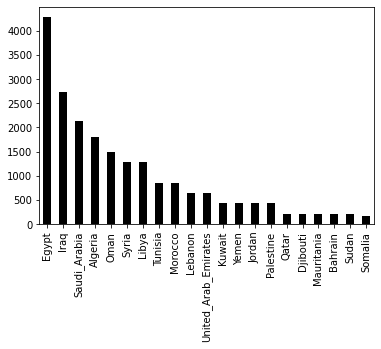

In [9]:
fig, ax = plt.subplots()
train_data['#3_country_label'].value_counts().plot(ax=ax, kind='bar',colormap=plt.cm.gray)

<AxesSubplot:>

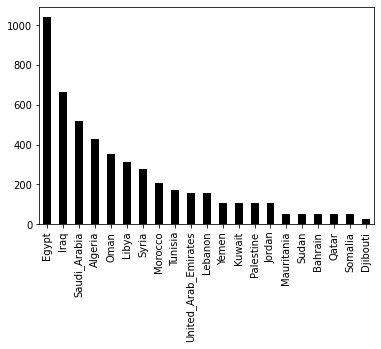

In [10]:
fig, ax = plt.subplots()
test_data['#3_country_label'].value_counts().plot(ax=ax, kind='bar',colormap=plt.cm.gray)

In [11]:
# test_data['#3_country_label'].value_counts()

In [12]:
# train_data['#3_country_label'].value_counts()

## preview samples 

In [13]:
# train_data.loc[train_data['#3_country_label'] == 'Somalia']

## clean tweets

### V0 cleaning

In [14]:
train_data['#2_tweet_clean_V0'] = (train_data['#2_tweet'].apply(clean_arabic_tweetV0))
test_data['#2_tweet_clean_V0'] = (test_data['#2_tweet'].apply(clean_arabic_tweetV0))

### farasa on V0 

In [15]:
train_data['#2_tweet_clean_farasaV0'] = (train_data['#2_tweet_clean_V0'].apply(farasa_segmenting))
test_data['#2_tweet_farasaV0'] = (test_data['#2_tweet_clean_V0'].apply(farasa_segmenting))

### V1 cleaning

In [16]:
tarin_tweets_cleaned = (train_data['#2_tweet'].apply(clean_arabic_tweet))
test_tweets_cleaned = (test_data['#2_tweet'].apply(clean_arabic_tweet))

In [17]:
train_data['#2_tweet_clean_V1']= tarin_tweets_cleaned
test_data['#2_tweet_clean_V1']= test_tweets_cleaned

### v2 cleaning

#### loading stopwords

In [18]:
#remove arabic formal clitics from tweets.
stop_words_file = open('formal clitics stop words.txt','r',encoding="utf8")
stop_words_list = [line.strip() for line in stop_words_file]

#### normalize the stop words

In [19]:
stop_words_list_preprocessed = []
for word in stop_words_list:
    word_processed = remove_diacritics(word)
    word_processed = normalize_arabic(word_processed)
    word_processed = remove_repeating_char(word_processed)
    word_processed = remove_diacritics(word_processed)
    word_processed = remove_diacritics(word_processed)
#     print(word, word_processed)
    if len(word_processed)>1:
        stop_words_list_preprocessed.append(word_processed)

In [20]:
removed_words = []

In [21]:
def remove_stopwords(text):
    text_tokens = text.strip().split(" ")
    for word in text_tokens:
        if word in stop_words_list_preprocessed:
            removed_words.append(word)            
    #------------------------------------------------------------------------------------------------
    tokens_filtered= [word for word in text_tokens if not word in stop_words_list_preprocessed]
    return (" ").join(tokens_filtered)




In [ ]:
train_data['#2_tweet_clean_V2']= train_data['#2_tweet_clean_V1'].apply(remove_stopwords)
    
test_data['#2_tweet_clean_V2']= test_data['#2_tweet_clean_V1'].apply(remove_stopwords)

In [ ]:
len(removed_words)

In [ ]:
with open("./removed_stopwords_from_tweet.txt", 'w', encoding="utf-8") as f:
    for word in removed_words:
        f.write(word+'\n')

### v3 cleaning

In [ ]:
train_data['#2_tweet_clean_V3'] = remove_duplicate_words(train_data['#2_tweet_clean_V2'])
test_data['#2_tweet_clean_V3']= remove_duplicate_words(test_data['#2_tweet_clean_V2'])


train_data['#2_tweet_clean_V3']= remove_rare_words(train_data['#2_tweet_clean_V3'], 1)
test_data['#2_tweet_clean_V3']= remove_rare_words(test_data['#2_tweet_clean_V3'], 1)


train_data['#2_tweet_clean_V3'] = remove_common_words(train_data['#2_tweet_clean_V3'], 0.90)
test_data['#2_tweet_clean_V3']= remove_common_words(test_data['#2_tweet_clean_V3'], 0.90)


#### delete empty tweets

In [ ]:
def remove_empty_tweets(df, column_name):
    nan_value = float("NaN")
    df.replace("", nan_value, inplace=True)
    df.dropna(subset = [column_name], inplace=True)
    return df


In [ ]:
remove_empty_tweets(train_data, "#2_tweet_clean_V1")
remove_empty_tweets(train_data, "#2_tweet_clean_V2")
remove_empty_tweets(train_data, "#2_tweet_clean_V3")

remove_empty_tweets(test_data, "#2_tweet_clean_V1")
remove_empty_tweets(test_data, "#2_tweet_clean_V2")
remove_empty_tweets(test_data, "#2_tweet_clean_V3")

#### add class id coloumn

In [ ]:
classes_names = train_data['#3_country_label'].unique().tolist()
classes_map={}
for i,class_name in enumerate(classes_names):
    classes_map[class_name]=i


def find_class_id_from_name(class_name):
    return classes_map[class_name]

In [ ]:
train_data['#classes_id']=train_data['#3_country_label'].apply(find_class_id_from_name)
test_data['#classes_id']=test_data['#3_country_label'].apply(find_class_id_from_name)

In [ ]:
train_data.head(20)

In [ ]:
test_data.head(10)

## save the cleaned data

In [ ]:
train_data.to_csv("./cleaned_data/cleaned_train_data_for_subtask1.csv", index=False)
test_data.to_csv("./cleaned_data/cleaned_test_data_for_subtask1.csv", index=False)

## get unique words - vocab

In [36]:
vocab = []
for tweet in tqdm(train_data['#2_tweet_clean_V3'].tolist()):
    for word in  text_to_word_sequence(tweet):
        if word not in vocab:
            vocab.append(word)


100%|███████████████████████████████████████████████████████████████████████████| 20974/20974 [01:02<00:00, 336.65it/s]


In [37]:
len(vocab)

48685

## find unique vocab of each country

In [38]:
class_unique_words = {}
for class_name in train_data['#3_country_label'].unique().tolist():
    class_unique_words[class_name] = []

In [39]:
looped = 0
for tweet, class_name in zip(train_data['#2_tweet_clean_V3'].tolist(), train_data['#3_country_label'].tolist()):
    looped+=1
    for word in text_to_word_sequence(tweet):
        if word not in class_unique_words[class_name]:
            exist_in_another_country = False
            for key in class_unique_words.keys():
                if key == class_name:
                    continue
                elif word in class_unique_words[key]:
                    exist_in_another_country = True
                    class_unique_words[key].remove(word)
                    break
            if exist_in_another_country==False:
                class_unique_words[class_name].append(word)

In [40]:
country_name_unique_vocab ={}
country_name, unique_vocab =[], []
for class_name in class_unique_words.keys():
    country_name_unique_vocab[class_name] = len(class_unique_words[class_name])
    country_name.append(class_name)
    unique_vocab.append(len(class_unique_words[class_name]))



In [41]:
country_name_unique_vocab

{'Egypt': 6668,
 'Iraq': 6043,
 'Saudi_Arabia': 4126,
 'Mauritania': 649,
 'Algeria': 4018,
 'Syria': 2795,
 'Oman': 2449,
 'Tunisia': 1830,
 'Lebanon': 1558,
 'Morocco': 2130,
 'Djibouti': 355,
 'United_Arab_Emirates': 978,
 'Kuwait': 758,
 'Libya': 2483,
 'Bahrain': 362,
 'Qatar': 367,
 'Yemen': 895,
 'Palestine': 710,
 'Jordan': 718,
 'Somalia': 271,
 'Sudan': 375}

In [42]:
country_name_unique_vocab_df = df_ = pd.DataFrame(index=range(0,21), columns=['country_name', 'unique_vocab_count'])


In [43]:
country_name_unique_vocab_df['country_name'] = country_name
country_name_unique_vocab_df['unique_vocab_count'] = unique_vocab


In [44]:
country_name_unique_vocab_df.head(21)

,country_name,unique_vocab_count
0,Egypt,6668
1,Iraq,6043
2,Saudi_Arabia,4126
3,Mauritania,649
4,Algeria,4018
5,Syria,2795
6,Oman,2449
7,Tunisia,1830
8,Lebanon,1558
9,Morocco,2130


In [45]:
country_name_unique_vocab_df=country_name_unique_vocab_df.sort_values(by=['unique_vocab_count'], ascending=False)

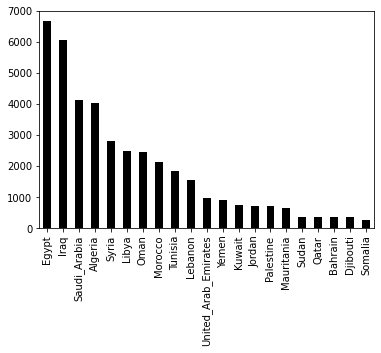

In [53]:
country_name_unique_vocab_df.plot(x='country_name', y='unique_vocab_count', kind='bar',colormap=plt.cm.gray,legend=False)
plt.xlabel("")
plt.show()